In [9]:
import re
import pandas as pd
from datetime import datetime
from pathlib import Path
log_pattern = re.compile(
    r'(?P<host>\S+)\s+'              # host
    r'\S+\s+\S+\s+'                  # ignore ident, authuser
    r'\[(?P<time>.*?)\]\s+'          # timestamp
    r'"(?P<method>\S+)\s+'           # HTTP method
    r'(?P<url>\S+)\s*'               # URL
    r'\S*"\s+'                       # protocol
    r'(?P<status>\d{3})\s+'          # status code
    r'(?P<bytes>\S+)'                # bytes
)

In [10]:
!git clone https://github.com/myprivatelearningacc/Autoscaling-Analysis.git


Cloning into 'Autoscaling-Analysis'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 8.73 KiB | 2.91 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
%cd Autoscaling-Analysis

[Errno 2] No such file or directory: 'Autoscaling-Analysis'
/content


In [3]:
!pip install gdown

In [4]:
!mkdir -p data/raw

In [5]:
!gdown 1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk -O data/raw/train.txt

Downloading...
From (original): https://drive.google.com/uc?id=1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk
From (redirected): https://drive.google.com/uc?id=1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk&confirm=t&uuid=dd6cfaac-918a-4ead-83e8-c452ac975054
To: /content/data/raw/train.txt
100% 320M/320M [00:05<00:00, 54.9MB/s]


In [6]:
from pathlib import Path

DATA_PATH = Path("data/raw/train.txt")
print("File exists:", DATA_PATH.exists())
print("File size (MB):", DATA_PATH.stat().st_size / 1e6)


File exists: True
File size (MB): 319.688542


In [7]:
with open(DATA_PATH, "r", encoding="latin-1") as f:
    for _ in range(5):
        print(f.readline())


199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245

unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985

199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085

burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0

199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179



In [22]:
DATA_PATH = Path("data/raw/train.txt")
records = []

with open(DATA_PATH, "r", encoding="latin-1") as f:
    for line in f:
        match = log_pattern.search(line)
        if match:
            data = match.groupdict()

            # bytes: "-" → 0
            data["bytes"] = int(data["bytes"]) if data["bytes"].isdigit() else 0

            # timestamp → datetime
            data["time"] = datetime.strptime(
                data["time"], "%d/%b/%Y:%H:%M:%S %z"
            )

            records.append(data)

df = pd.DataFrame(records)
df.head()


,host,time,method,url,status,bytes
0,199.72.81.55,1995-07-01 00:00:01-04:00,GET,/history/apollo/,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06-04:00,GET,/shuttle/countdown/,200,3985
2,199.120.110.21,1995-07-01 00:00:09-04:00,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,4085
3,burger.letters.com,1995-07-01 00:00:11-04:00,GET,/shuttle/countdown/liftoff.html,304,0
4,199.120.110.21,1995-07-01 00:00:11-04:00,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,200,4179


In [23]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933924 entries, 0 to 2933923
Data columns (total 6 columns):
 #   Column  Dtype                    
---  ------  -----                    
 0   host    object                   
 1   time    datetime64[ns, UTC-04:00]
 2   method  object                   
 3   url     object                   
 4   status  object                   
 5   bytes   int64                    
dtypes: datetime64[ns, UTC-04:00](1), int64(1), object(4)
memory usage: 134.3+ MB


,0
host,0
time,0
method,0
url,0
status,0
bytes,0


In [24]:
df["status"].value_counts().head()
df["bytes"].astype("int64")

,bytes
0,6245
1,3985
2,4085
3,0
4,4179
...,...
2933919,5866
2933920,786
2933921,363
2933922,234


/tmp/ipython-input-3062759727.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  requests_5m = df.resample("5T").size()


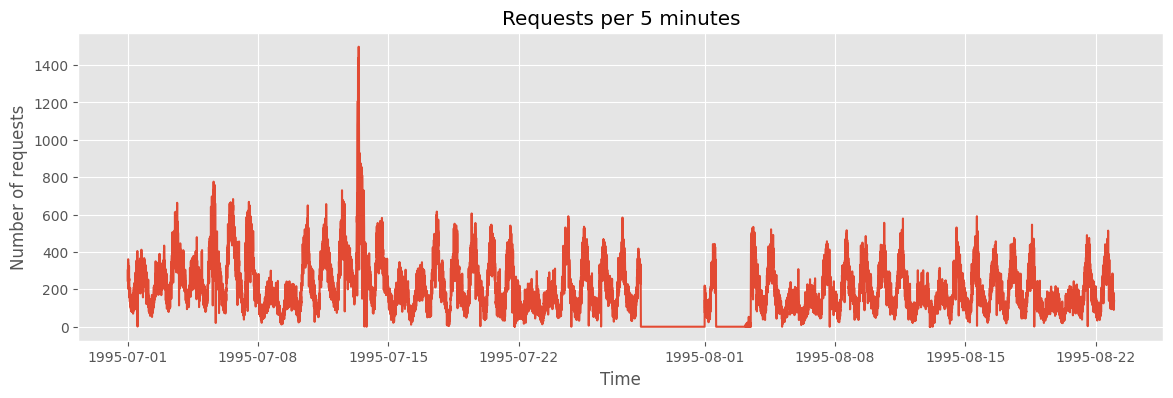

In [25]:
import matplotlib.pyplot as plt
df = df.set_index("time").sort_index()

requests_5m = df.resample("5T").size()

plt.figure(figsize=(14,4))
plt.plot(requests_5m)
plt.title("Requests per 5 minutes")
plt.ylabel("Number of requests")
plt.xlabel("Time")
plt.show()

/tmp/ipython-input-2496996480.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bytes_5m = df["bytes"].resample("5T").sum()


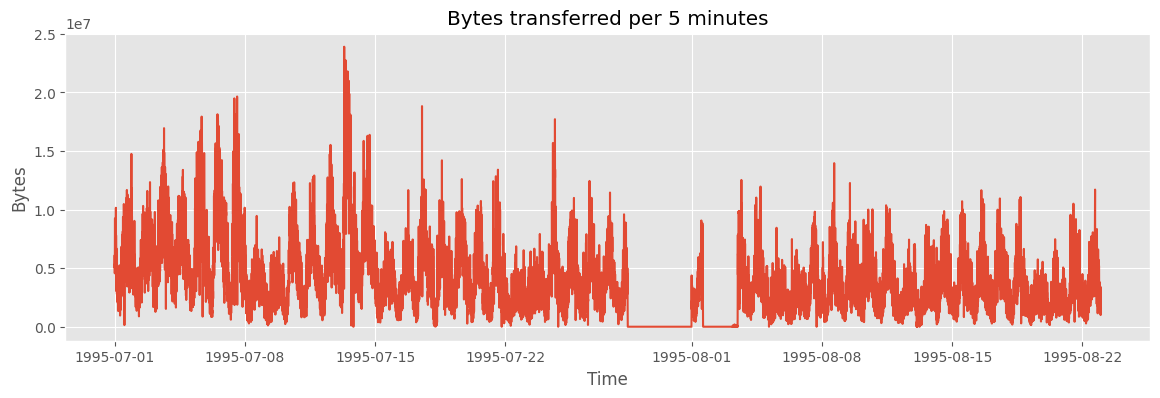

In [26]:
bytes_5m = df["bytes"].resample("5T").sum()

plt.figure(figsize=(14,4))
plt.plot(bytes_5m)
plt.title("Bytes transferred per 5 minutes")
plt.ylabel("Bytes")
plt.xlabel("Time")
plt.show()

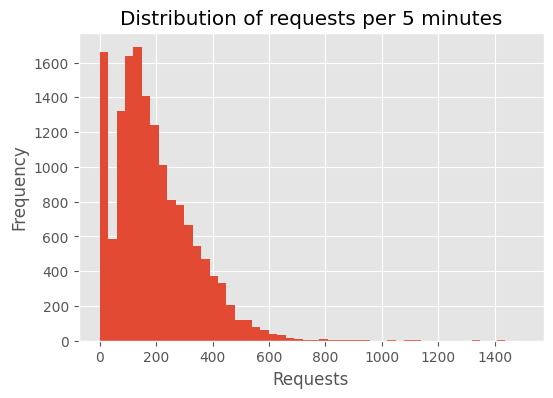

In [28]:
plt.figure(figsize=(6,4))
plt.hist(requests_5m, bins=50)
plt.title("Distribution of requests per 5 minutes")
plt.xlabel("Requests")
plt.ylabel("Frequency")
plt.show()

In [29]:
clean_path = "Ingest_EDA.csv"
df.to_csv(clean_path, index=False)
print("Saved to", clean_path)

Saved to Ingest_EDA.csv
